##### Copyright 2018 The TensorFlow Authors.

In [1]:
#BOUT Nassim

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
!pip install tensorflow_datasets

You should consider upgrading via the 'c:\users\nassim\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.



In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


45058 examples [07:00, 100.22 examples/s]
45069 examples [07:00, 98.26 examples/s] 
45082 examples [07:00, 104.04 examples/s]
45093 examples [07:00, 94.44 examples/s] 
45104 examples [07:00, 98.42 examples/s]
45120 examples [07:00, 109.28 examples/s]
45135 examples [07:00, 118.17 examples/s]
45148 examples [07:00, 121.34 examples/s]
45161 examples [07:00, 118.43 examples/s]
45178 examples [07:01, 129.44 examples/s]
45192 examples [07:01, 128.94 examples/s]
45206 examples [07:01, 110.15 examples/s]
45219 examples [07:01, 114.54 examples/s]
45232 examples [07:01, 117.22 examples/s]
45246 examples [07:01, 122.11 examples/s]
45259 examples [07:01, 109.68 examples/s]
45271 examples [07:01, 105.96 examples/s]
45282 examples [07:02, 100.28 examples/s]
45296 examples [07:02, 106.97 examples/s]
45310 examples [07:02, 114.01 examples/s]
45322 examples [07:02, 109.89 examples/s]
45334 examples [07:02, 108.84 examples/s]
45348 examples [07:02, 116.51 examples/s]
45360 examples [07:02, 113.28 exam

 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [16]:
encoder = info.features['text'].encoder

In [7]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [8]:
sample_string = 'Hi TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [1052, 7961, 6307, 2327, 4043, 2120, 7975]
The original string: "Hi TensorFlow."


In [9]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

1052 ----> Hi
7961 ---->  
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

Compile the Keras model to configure the training process:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 4114s 11s/step - loss: 0.6604 - accuracy: 0.5484 - val_loss: 0.5407 - val_accuracy: 0.7563
Epoch 2/10
391/391 [==============================] - 2105s 5s/step - loss: 0.3981 - accuracy: 0.8273 - val_loss: 0.3663 - val_accuracy: 0.8297
Epoch 3/10
391/391 [==============================] - 1717s 4s/step - loss: 0.2659 - accuracy: 0.8922 - val_loss: 0.3234 - val_accuracy: 0.8714
Epoch 4/10
391/391 [==============================] - 1616s 4s/step - loss: 0.2140 - accuracy: 0.9194 - val_loss: 0.3206 - val_accuracy: 0.8682
Epoch 5/10
391/391 [==============================] - 1757s 4s/step - loss: 0.1905 - accuracy: 0.9290 - val_loss: 0.3290 - val_accuracy: 0.8682
Epoch 6/10
391/391 [==============================] - 2042s 5s/step - loss: 0.1679 - accuracy: 0.9388 - val_loss: 0.3856 - val_accuracy: 0.8672
Epoch 7/10
391/391 [==============================] - 2101s 5s/step - loss: 0.1565 - accuracy: 0.9426 - val_loss: 0.3557 - val_accuracy

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 220s 562ms/step - loss: 0.4253 - accuracy: 0.8480
Test Loss: 0.42529410123825073
Test Accuracy: 0.848039984703064


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [18]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [19]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [20]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.02159701]]


In [21]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.26982334]]


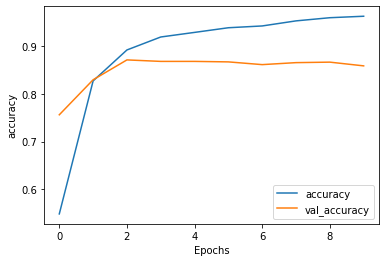

In [22]:
plot_graphs(history, 'accuracy')

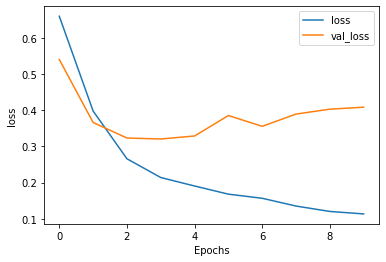

In [23]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [0]:
plot_graphs(history, 'accuracy')

In [0]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
